<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2025/blob/main/notebooks/es_12.6/MetodiAI_Fis2025_E17_QML_ClassificazioneBinaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercitazione E17: A QNN based on Parametric Quantum Circuit for binary classification of MNIST images


**Version:** V2.1 <p>
**Authors:** Stefano Giagu <stefano.giagu@uniroma1.it>


**Scope:**: learn how to design a simple variational PQC and train it for a binary classification task using the [pennylane](https://pennylane.ai/) platform with [pytorch](https://pytorch.org/) backend

**Libraries:** numpy, matplotlib, pytorch, pennylane

In [ ]:
# install pennylane on colab
!pip install pennylane-lightning-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.5 MB/s eta 0:00:00


In [ ]:
# import needed libraries
import numpy as np
import matplotlib.pyplot as plt
import os

from time import time
from tqdm import tqdm

import torch
import pennylane as qml
print('Torch version: ', torch.__version__)
print('Pennylane version: ', qml.__version__)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Torch version:  2.6.0+cu124
Pennylane version:  0.41.1


In [ ]:
# check if GPU is available
# Note: the example can also be run on CPU w/o problems

if torch.cuda.is_available():
  print('Number of available GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
  !nvidia-smi
else:
  print('No GPU available')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of available GPUs:  1
Tesla T4
Sun Jun  8 09:33:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------

In [ ]:
# check Pennylane software stack
qml.about()

Name: PennyLane
Version: 0.41.1
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: appdirs, autograd, autoray, cachetools, diastatic-malt, networkx, numpy, packaging, pennylane-lightning, requests, rustworkx, scipy, tomlkit, typing-extensions
Required-by: PennyLane_Lightning, PennyLane_Lightning_GPU

Platform info:           Linux-6.1.123+-x86_64-with-glibc2.35
Python version:          3.11.13
Numpy version:           2.0.2
Scipy version:           1.15.3
Installed devices:
- lightning.qubit (PennyLane_Lightning-0.41.1)
- default.clifford (PennyLane-0.41.1)
- default.gaussian (PennyLane-0.41.1)
- default.mixed (PennyLane-0.41.1)
- default.qubit (PennyLane-0.41.1)
- default.qutrit (PennyLane-0.

In [ ]:
# Download MNIST dataset (from torchvision repository)

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Download MNIST and prepare transforms
# we donwsample MNIST images from 28x28 to 16x16 pixels in order to reduce the number of qubit needed to represent each image
mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.Compose([
                                transforms.Resize((16, 16)),                # Resize to 16x16
                                transforms.ToTensor(),                      # Convert to torch tensors
                                transforms.Normalize((0.1307,), (0.3081,))  # Normalize
                             ]))

# Filter for zeros and ones (in the example we train the QNN for a binary task, classification of 0 and 1 digits)
data = []
targets = []
for image, label in mnist_train:
    if label in [0, 1]:
        data.append(image.squeeze())
        targets.append(label)

data = torch.stack(data)
targets = torch.tensor(targets)

# Select zeros and ones to implement a simpler binary classification problem
zeros_indices = (targets == 0)
ones_indices = (targets == 1)

zeros = data[zeros_indices]
ones = data[ones_indices]

# take a subset of the dataset to limit the training time: 1024 zeros and 1024 ones for training and an equal size set for test
zeros_train = zeros[:1024]
ones_train = ones[:1024]

zeros_test = zeros[1024:2048]
ones_test = ones[1024:2048]

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.25MB/s]


In [ ]:
# normalize images in [0,1]

def normalize(imgs):
  maxes, _ = torch.max(imgs.reshape(-1, 16*16), dim = 1)
  mins, _ = torch.min(imgs.reshape(-1, 16*16), dim = 1)

  mins = mins.unsqueeze(1).unsqueeze(2)
  maxes = maxes.unsqueeze(1).unsqueeze(2)

  return (imgs-mins)/(maxes-mins)

zeros_train = normalize(zeros_train)
ones_train = normalize(ones_train)

zeros_test = normalize(zeros_test)
ones_test = normalize(ones_test)

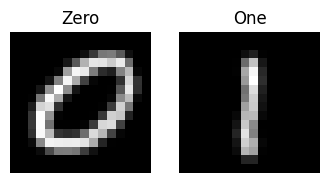

In [ ]:
# plot two examples of the input images

# Select a random sample index
zero_idx = np.random.randint(0, zeros_train.shape[0])
one_idx = np.random.randint(0, ones_train.shape[0])

# Extract the images
sample_zero = zeros_train[zero_idx]
sample_one = ones_train[one_idx]

# Plot the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))

ax1.imshow(sample_zero, cmap='gray')
ax1.set_title('Zero')
ax1.axis('off')

ax2.imshow(sample_one, cmap='gray')
ax2.set_title('One')
ax2.axis('off')

plt.show()

In [ ]:
# assert images have min 0 and max 1 within an error of 1e-5
assert torch.allclose(zeros_train.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(zeros_train.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones_train.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones_train.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)

assert torch.allclose(zeros_test.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(zeros_test.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones_test.min(), torch.tensor(0., dtype = torch.float32), atol=1e-5)
assert torch.allclose(ones_test.max(), torch.tensor(1., dtype = torch.float32), atol=1e-5)

# concatenate the zeros and ones datasets in just one training dataset
zeros_train = zeros_train.flatten(start_dim = 1)
ones_train = ones_train.flatten(start_dim = 1)
dataset_train = torch.cat((zeros_train, ones_train), dim = 0)

# same for test
zeros_test = zeros_test.flatten(start_dim = 1)
ones_test = ones_test.flatten(start_dim = 1)
dataset_test = torch.cat((zeros_test, ones_test), dim = 0)

# add labels
labels_train = torch.cat((torch.zeros((zeros_train.shape[0], 1)), torch.ones((ones_train.shape[0], 1))), dim = 0).squeeze()
labels_test = torch.cat((torch.zeros((zeros_test.shape[0], 1)), torch.ones((ones_test.shape[0], 1))), dim = 0).squeeze()

In [ ]:
# build torch datasets and dataloaders
BATCH_SIZE = 32

# build dataset
dataset_train = torch.utils.data.TensorDataset(dataset_train, labels_train)
dataset_test = torch.utils.data.TensorDataset(dataset_test, labels_test)

#build dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

In [ ]:
# Define a quantum device (eg the number of qubits in the circuit)


NUM_QUBITS = 8 # we need 8 qubits to encode 16x16 features
NUM_LAYERS = 3 #n umber of layers in the QNN (each layer is composed by a parametric unitary transformation given by 3 rotation and CNOT gates to entangle qubits)

# definition of the quantum parametric circuit
# the circuit ansatz is made by NUM_LAYERS of the same unitary block made of a 3 parametric rotations gates(along X, Y and Z) in the block sphere for each qubit, folloeed by a ladder of CNOT
# gates to entangle the qubits

dev = qml.device("default.qubit", wires=NUM_QUBITS) #"default.qubit" is the default pennylane differentiable quantum device simulator that is capable of backprop derivatives

@qml.qnode(dev, interface="torch")
def circuit_block(params, state=None):

    # Load the initial state if provided
    # quantum encoding (using amplitude encoding: Encodes 2𝑛 features into the amplitude vector of 𝑛 qubits), to represent a valid quantum state vector, the L2-norm of features must be one, this can be achieved
    # either by manually normalizing the data (ex: state = state / torch.linalg.norm(state, dim=1).view(-1, 1)), or automatically by setting the argument normalize=True
    if state is not None: qml.AmplitudeEmbedding(features=state, wires=range(NUM_QUBITS), normalize=True)

    # Alternatively as we are in simulation also a simplified encoding as normalized state vector can be used (ok in simulation, allows to skip quantum encoding of the classical
    # data, requires the input to be pre-normalized as a quantum state (eg L2 norm = 1.0: state = state / torch.linalg.norm(state, dim=1).view(-1, 1)))
    # if state is not None: qml.QubitStateVector(state, wires=range(NUM_QUBITS))

    # Quantum circuit
    for i in range(NUM_LAYERS):

      # Rotation layer
      for j in range(NUM_QUBITS):
          qml.RX(params[i, j, 0], wires=j)   #params is the vector containing the PQC paraneters: size = (NUM_LAYERS, NUM_QUBITS, NUM_ROTATIONS) --> ex. in our case: 3*8*3=72 parameters
          qml.RY(params[i, j, 1], wires=j)
          qml.RZ(params[i, j, 2], wires=j)

      # Entangling layer (a ladder of CNOT gates)
      for j in range(NUM_QUBITS):
          qml.CNOT(wires=[j, (j + 1) % NUM_QUBITS]) # note: when j=NUM_QUBITS-1 ->  (j+1)%NUM_QUBITS = 0

    # Return the probability of measuring one of the base vector in the first qubit
    return qml.probs(wires=0)

  # define general circuit
def circuit(params, state):

    # apply quantum circuit
    basis_state_proba = circuit_block(params, state)

    # return probability of measuring |0> in the first qubit
    return basis_state_proba[:,0]

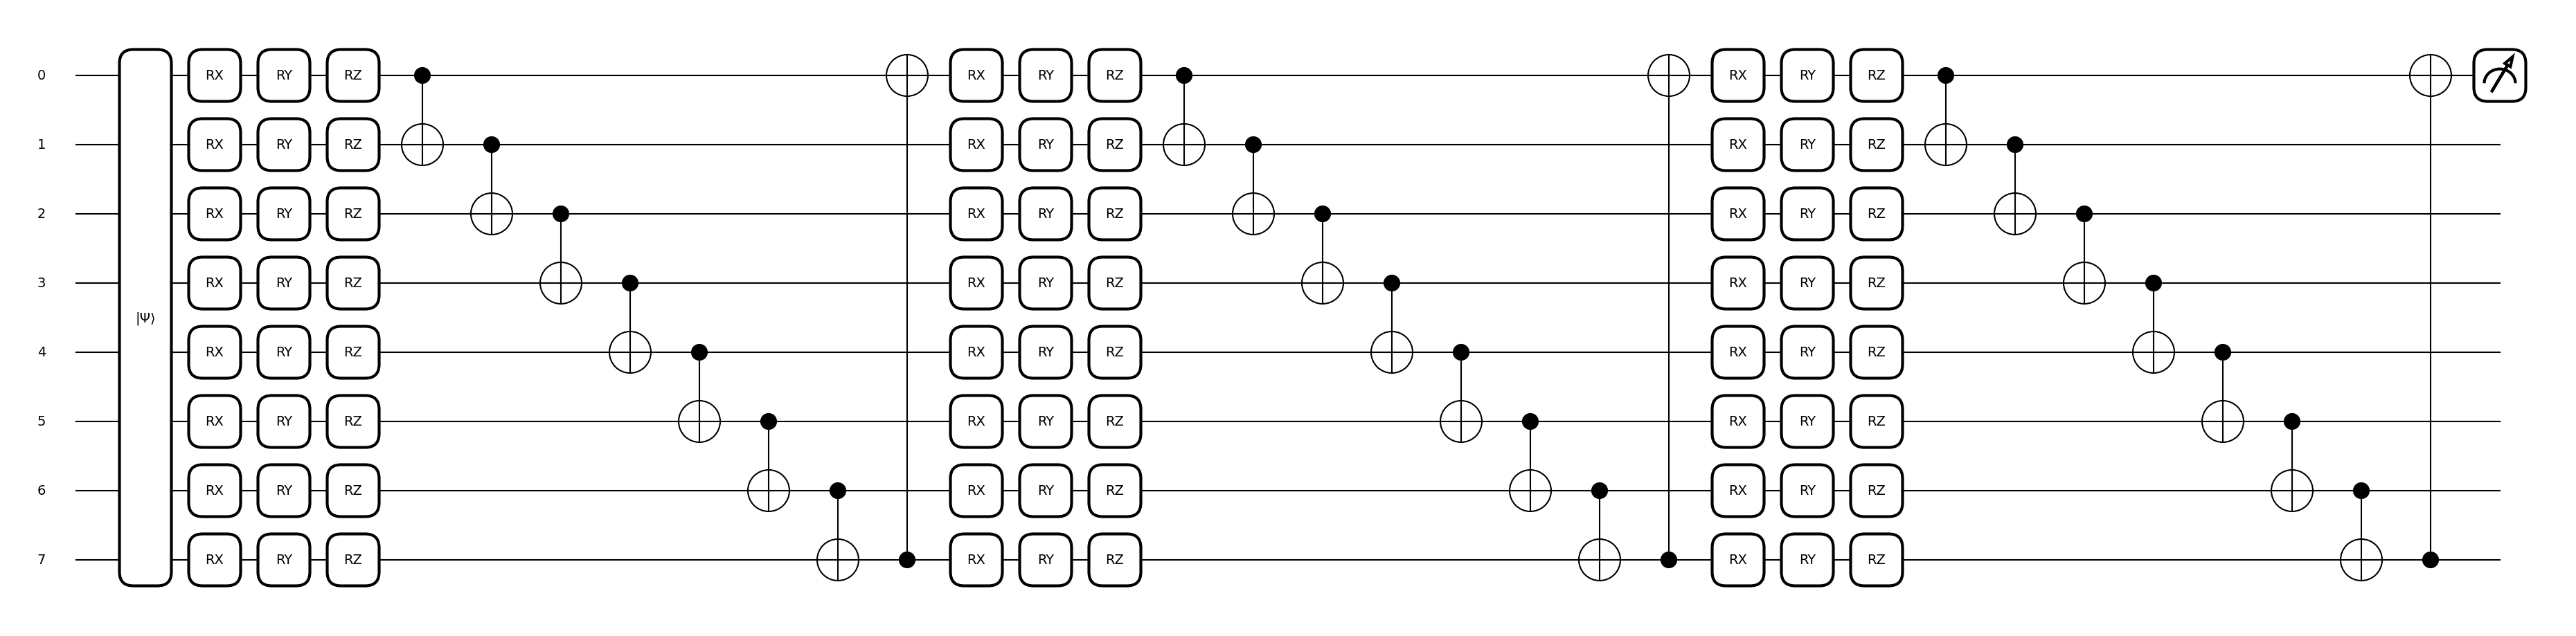

In [ ]:
# visualize the qnn
from torch.autograd import Variable

parameters = Variable(torch.normal( mean=0. , std=0.1, size=(NUM_LAYERS, NUM_QUBITS, 3)), requires_grad=True)

state,_ = next(iter(dataloader_train))
#state = state / torch.linalg.norm(state, dim=1).view(-1, 1) #needed in case the qml.QubitStateVector encoding is used

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit_block)(parameters, state)
plt.show()

In [ ]:
def run_exp(batch_size, num_epochs, dataloader, loss_fn):

    loss_history = []
    accuracy_history = []

    avg_time_per_epoch = 0

    # training loop for classification
    for epoch in range(num_epochs):

        t0 = time()

        # Initialize tqdm progress bar with description showing the current epoch
        with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as tqdm_epoch:
            for _, (data, labels) in tqdm_epoch:

                #needed in case the qml.QubitStateVector encoding is used
                #data = data / torch.linalg.norm(data, dim=1).view(-1, 1)

                # zero the parameter gradients
                optimizer.zero_grad()

                data = data.type(torch.float).to(device=device)
                labels = labels.type(torch.float).to(device=device)

                # forward pass
                output = circuit(params, data).to(device=device)

                # compute the loss
                loss = loss_fn(output, labels)

                # backward pass
                loss.backward()

                # update the parameters
                optimizer.step()

                # accuracy
                accuracy_t=torch.sum((output > 0.5) == labels).item() / batch_size

                # Optionally, update tqdm bar with batch loss
                tqdm_epoch.set_postfix(loss=loss.item(), accuracy=accuracy_t)

        avg_time_per_epoch += time()-t0

        loss_history.append(loss.item())
        accuracy_history.append(accuracy_t)

        # print the time
        print("Time per epoch: ", time()-t0)

        # print the loss
        print("Epoch: ", epoch, "Loss: ", loss.item())

        # print the accuracy
        print("Accuracy: ", accuracy_t)

        print("--------------------------------------------------------------------------")

    return avg_time_per_epoch/NUM_EPOCHS, loss_history, accuracy_history

In [ ]:
def run_test(batch_size, dataloader, loss_fn):

    t_loss = 0.0
    t_accuracy = 0.0

    counter = 0
    for data, labels in dataloader:

        counter += 1
        # normalize
        #data = data / torch.linalg.norm(data, dim=1).view(-1, 1)

        data = data.type(torch.float).to(device=device)
        labels = labels.type(torch.float).to(device=device)

        # forward pass
        output = circuit(params, data)

        # compute the loss
        loss = loss_fn(output, labels)

        # accuracy
        accuracy = torch.sum((output > 0.5) == labels).item()/batch_size


        t_loss += loss.item()
        t_accuracy += accuracy

    print("Test loss: ", t_loss/counter)
    print("Test accuracy: ", t_accuracy/counter)

    return

In [ ]:
# parametres
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

# define the cost function (Binary X-entropy)
loss_fn = torch.nn.BCELoss()

# initialize parameters randomly
params = torch.randn((NUM_LAYERS, NUM_QUBITS, 3), requires_grad=True)

# define the optimizer
optimizer = torch.optim.Adam([params], lr=LEARNING_RATE)

# training
print(f'\nRunning experiment with batch size {BATCH_SIZE} and layers {NUM_LAYERS}\n')

time_per_epoch, loss_history, accuracy_history = run_exp(BATCH_SIZE, NUM_EPOCHS, dataloader_train, loss_fn)

print(f'Average time per epoch: {time_per_epoch} - BS: {BATCH_SIZE} - LAYERS: {NUM_LAYERS}\n')
print('='*50)


Running experiment with batch size 32 and layers 3



Epoch 1/10: 100%|██████████| 64/64 [00:09<00:00,  6.72it/s, accuracy=0.719, loss=0.666]


Time per epoch:  9.522904872894287
Epoch:  0 Loss:  0.6656773686408997
Accuracy:  0.71875
--------------------------------------------------------------------------


Epoch 2/10: 100%|██████████| 64/64 [00:06<00:00,  9.85it/s, accuracy=0.969, loss=0.622]


Time per epoch:  6.499608993530273
Epoch:  1 Loss:  0.6224440932273865
Accuracy:  0.96875
--------------------------------------------------------------------------


Epoch 3/10: 100%|██████████| 64/64 [00:07<00:00,  9.04it/s, accuracy=0.969, loss=0.567]


Time per epoch:  7.079983234405518
Epoch:  2 Loss:  0.5671603679656982
Accuracy:  0.96875
--------------------------------------------------------------------------


Epoch 4/10: 100%|██████████| 64/64 [00:07<00:00,  8.69it/s, accuracy=1, loss=0.55]


Time per epoch:  7.373464822769165
Epoch:  3 Loss:  0.5498406887054443
Accuracy:  1.0
--------------------------------------------------------------------------


Epoch 5/10: 100%|██████████| 64/64 [00:06<00:00,  9.62it/s, accuracy=0.938, loss=0.501]


Time per epoch:  6.656289100646973
Epoch:  4 Loss:  0.5011348724365234
Accuracy:  0.9375
--------------------------------------------------------------------------


Epoch 6/10: 100%|██████████| 64/64 [00:07<00:00,  9.04it/s, accuracy=1, loss=0.453]


Time per epoch:  7.081209182739258
Epoch:  5 Loss:  0.45338648557662964
Accuracy:  1.0
--------------------------------------------------------------------------


Epoch 7/10: 100%|██████████| 64/64 [00:07<00:00,  8.22it/s, accuracy=1, loss=0.422]


Time per epoch:  7.78999400138855
Epoch:  6 Loss:  0.4218946695327759
Accuracy:  1.0
--------------------------------------------------------------------------


Epoch 8/10: 100%|██████████| 64/64 [00:06<00:00,  9.15it/s, accuracy=1, loss=0.396]


Time per epoch:  6.998487949371338
Epoch:  7 Loss:  0.3959023952484131
Accuracy:  1.0
--------------------------------------------------------------------------


Epoch 9/10: 100%|██████████| 64/64 [00:06<00:00,  9.89it/s, accuracy=0.969, loss=0.381]


Time per epoch:  6.475391149520874
Epoch:  8 Loss:  0.38121551275253296
Accuracy:  0.96875
--------------------------------------------------------------------------


Epoch 10/10: 100%|██████████| 64/64 [00:07<00:00,  9.09it/s, accuracy=0.969, loss=0.388]

Time per epoch:  7.040747880935669
Epoch:  9 Loss:  0.38778239488601685
Accuracy:  0.96875
--------------------------------------------------------------------------
Average time per epoch: 7.251734948158264 - BS: 32 - LAYERS: 3



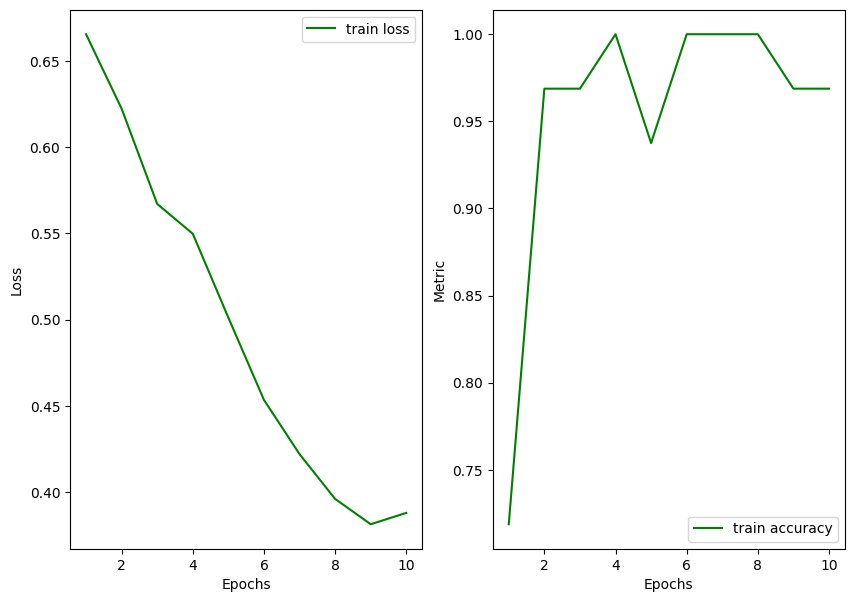

In [ ]:
# grafico monitoring training
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(loss_history)+1), loss_history, color='green', linestyle='-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(accuracy_history)+1),accuracy_history, color='green', linestyle='-', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
# test performance

run_test(BATCH_SIZE, dataloader_test, loss_fn)

Test loss:  0.3590647988021374
Test accuracy:  0.9873046875


## Esercizi Suggeriti:

* Giocare con il modello: modificare il numero di layer, ridurre l'entanglement, ... e verificare l'effetto sulle prestazioni di classificazione.
* Estendere il modello alla classificazione multi-classe su MNIST: potete provare, ad esempio, a usare 4 classi, che possono essere descritte leggendo 2 qubit di output (00, 01, 10, 11), oppure 8 classi, che possono essere descritte leggendo 3 qubit di output (000, 100, 010, 001, 110, 101, 011, 111).
* Provare ad utilizzare altri algoritmi di codifica dei dati, come la codifica angolare: AngleEmbedding(features, wires[, rotation, id]) che codifica 𝑁 feature negli angoli di rotazione di 𝑛 qubit, dove 𝑁 ≤ 𝑛.
NOTA: a causa di questa limitazione e del numero ridotto di qubit utilizzabili nella simulazione, è preferibile ridurre le immagini fino a un massimo di (4,4) pixel → 16 qubit (sarà piuttosto lento).
